# Training regression models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/1.intro-regression-training-cars.ipynb)

Load toy cars data set and train regression models to predict miles per gallon (MPG) through a variety of techniques. We start out doing a brute force grid search of many different slope and intercept (m, b) model parameters, looking for the best fit. Then we manually compute partial derivatives of the loss function and perform gradient descent using plain numpy. We look at the effect on the loss function of normalizing numeric variables to have zero mean and standard deviation one. Finally, this notebook shows you how to use the autograd (auto differentiation) functionality of pytorch as a way to transition from numpy to pytorch training loops.

## Support code

In [14]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import colors

In [15]:
def carshow(m, b, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    
    plt.show()

In [16]:
def mse(X,y,m,b):
    y_pred = m * X + b
#     return mean_squared_error(y, y_pred)
    return np.mean((y.reshape(-1,1)-y_pred.reshape(-1,1))**2)

def linmodel_coeff(X,y):
    lm = LinearRegression(normalize=False, fit_intercept=True)
    lm.fit(X, y)
#     print(lm.intercept_, lm.coef_)
    b = lm.intercept_[0]
    m = lm.coef_[0][0]
    return m,b

def grid_pairs(mrange, brange, n=100):
    pairs = [(m,b) for m in np.linspace(*mrange,num=n)
                   for b in np.linspace(*brange,num=n)]
    return np.array(pairs)

def loss_plot(m, b, z, truth=None, zmax=None, ax=None):
    cmap = plt.get_cmap('coolwarm')
    if zmax is not None:
        z = np.clip(z,min(z),zmax)
    norm = colors.Normalize(min(z),max(z))
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))
    if truth:
        tm,tb = truth
        ax.plot(tm, tb, 'x', ms=10, c='k')
    ax.scatter(m, b, s=30, c=cmap(norm(z)), alpha=1, marker='s')
    ax.set_xlabel("Slope m")
    ax.set_ylabel("Y-intercept b")
    ax.set_title("MSE linear model loss function")

def show(X, y, m, b, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")

def explain(X, y, mrange, brange, normalize=False, zmax=None, file=None):
    if normalize:
        X = (X-np.mean(X))/np.std(X)

    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    m,b = linmodel_coeff(X,y)
    print(m,b,mse(X,y,m,b))
#     print(f"m = {m:.2f}, b = {b:.2f}")    
    pairs = grid_pairs(mrange, brange, n=50)
    z = np.array([mse(X,y,*pair) for pair in pairs])
    loss_plot(pairs[:,0], pairs[:,1], z, truth=(m,b), ax=axes[0], zmax=zmax)
    show(X, y, m, b, ax=axes[1], file=file)

## Load simple data set

You need to download cars.csv and put into a `data` subdirectory:

In [31]:
! mkdir -p data
! curl --silent https://raw.githubusercontent.com/parrt/fundamentals-of-deep-learning/main/notebooks/data/cars.csv > data/cars.csv

In [17]:
df_cars = pd.read_csv("data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


## Brute force grid search

In [18]:
# brute force model parameter space search (m,b)
best = (1e100,0,0)
for m in np.linspace(-0.005,-.01,num=5):
    for b in np.linspace(42,47,num=5):
        y = m * df_cars.WGT + b
        loss = np.mean((y - df_cars.MPG)**2) # MSE
        if loss < best[0]:
            best = (loss,m,b)
        print(f"{m:4.3f},{b:4.3f} => MSE {loss:.1f}")
m = best[1]
b = best[2]
print(f"BEST {m:.3f}*x + {b:.3f}")

-0.005,42.000 => MSE 37.2
-0.005,43.250 => MSE 47.9
-0.005,44.500 => MSE 61.7
-0.005,45.750 => MSE 78.7
-0.005,47.000 => MSE 98.8
-0.006,42.000 => MSE 20.1
-0.006,43.250 => MSE 21.5
-0.006,44.500 => MSE 26.1
-0.006,45.750 => MSE 33.7
-0.006,47.000 => MSE 44.5
-0.007,42.000 => MSE 33.0
-0.007,43.250 => MSE 25.1
-0.007,44.500 => MSE 20.3
-0.007,45.750 => MSE 18.7
-0.007,47.000 => MSE 20.2
-0.009,42.000 => MSE 75.8
-0.009,43.250 => MSE 58.6
-0.009,44.500 => MSE 44.5
-0.009,45.750 => MSE 33.6
-0.009,47.000 => MSE 25.8
-0.010,42.000 => MSE 148.6
-0.010,43.250 => MSE 122.1
-0.010,44.500 => MSE 98.7
-0.010,45.750 => MSE 78.5
-0.010,47.000 => MSE 61.4
BEST -0.007*x + 45.750


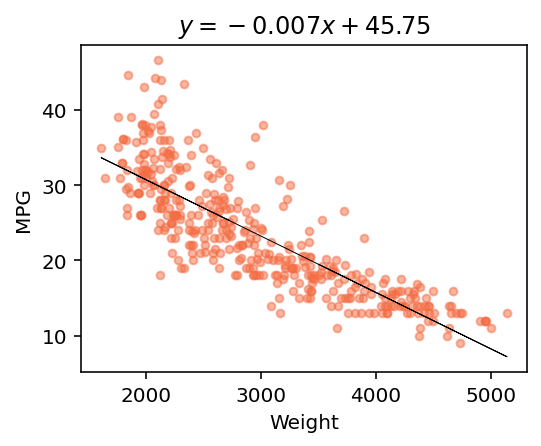

In [19]:
carshow(m, b, X=df_cars.WGT, y=df_cars.MPG)

## Manual gradient computation of loss function with numpy

use the sum, ignoring 1/n constant.

$$
loss = \sum_i^n E^2 \text{ where } E = \hat{y} - y = mx + b - y
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial m} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial m}\\
 & = & \sum_i^n E x\\
\end{array}
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial b} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial b}\\
 & = & \sum_i^n E\\
\end{array}
$$

Loss function is a saddle like this:

<img src="images/2d-loss.png" width="200">

Epoch     0 0.04,30.00: MSE loss    14801.948 MAE   115.64
Epoch    10 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    20 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    30 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    40 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    50 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    60 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    70 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    80 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch    90 -0.00,30.00: MSE loss       38.420 MAE     4.88
Epoch   100 -0.00,30.00: MSE loss       38.420 MAE     4.88
LAST        -0.00,30.00: MSE loss       38.420 MAE     4.88


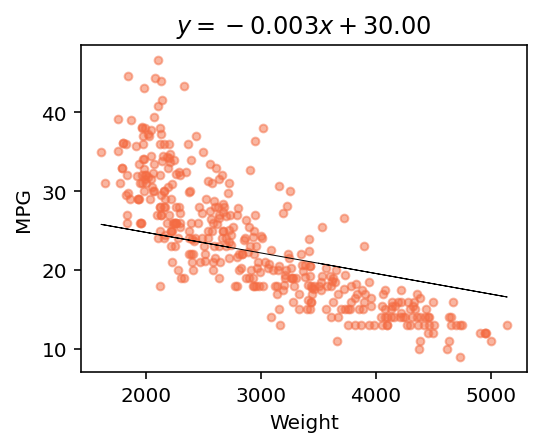

In [20]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
y = np.array(df_cars.MPG).reshape(n,1)

# Randomly initialize slope
m = np.random.random(size=1)[0]
b = 30.0 # get it close to final answer
# Loss surface is a valley; explodes if this learning rate is much bigger
learning_rate = .0000000003 # almost too fast for m, but incredibly slow for b.
nepochs=100
for epoch in range(nepochs+1):
    y_pred = m * X + b
    E = y_pred - y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Compute the gradient of loss with respect to m, b
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
carshow(m, b, X, y, file="lin")

## Standardized/normalized variables

Standardizing variables to be mean centered and with standard deviation one, improves convergence speed. Previously we had to choose a `b` that was very close to the answer.

The old but very useful article [Efficient BackProp by LeCun et al](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), describes why we need to standardize our X variables. I'm under the impression that getting all of the variances to 1.0 or at least similar, means we don't need learning rates per dimension (variable). The article indicates that we want the zero mean because "*any shift of the average input away from zero will bias the updates in a particular direction and thus slow down learning.*"  Consider the input layer to a network. We saw above that the derivative of the loss with respect to the $m$ slope parameter is the error, $E = y-\hat{y}$, times the $x_i$ input for variable $i$. LeCun points out that, if all inputs are positive, the $sign(E)$ dictates the direction we update the $m$ slopes. "*... these weights [$m$] can only all decrease or all increase together for a given input pattern. Thus, if a weight vector must change direction it can only do so by zigzagging which is inefficient and thus very slow.*"

-0.00764734245858457 46.21652431150987 18.676616404930005


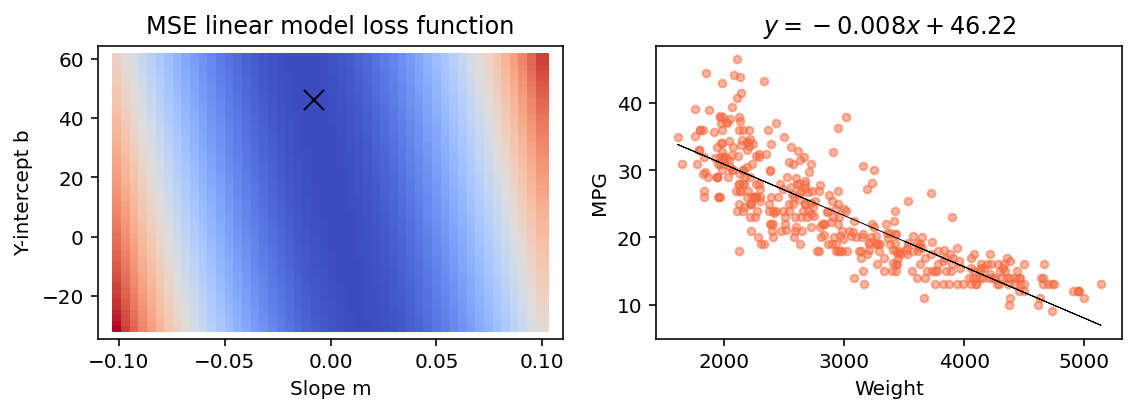

In [21]:
X = np.array(df_cars.WGT).reshape(n,1)
y = np.array(df_cars.MPG).reshape(n,1)
explain(X, y, mrange = (-.1,.1), brange = (-30,60), zmax=None, file="cars")

-6.487381674854015 23.445918359693877 18.67661640493001


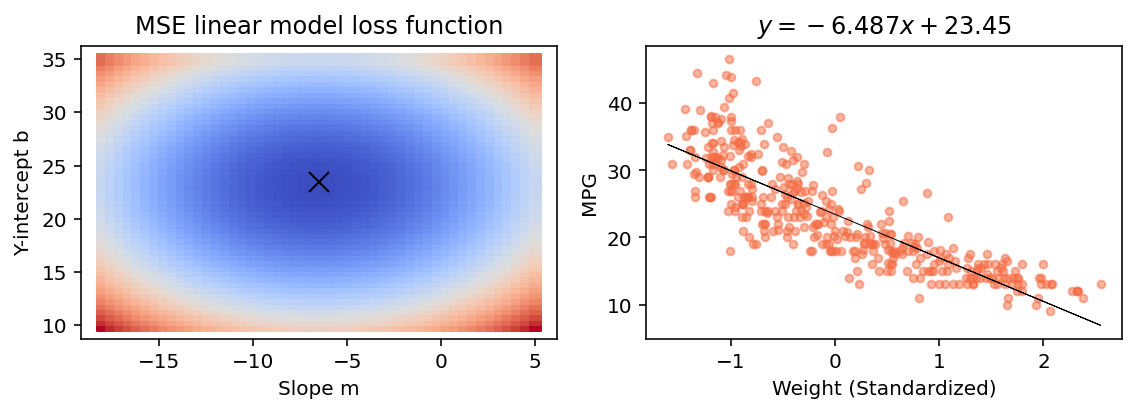

In [22]:
explain(X, y,
        mrange = (-18,5), brange = (10,35),
        normalize=True,
        file="cars-norm")

In [23]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
X = (X-np.mean(X))/np.std(X)
y = np.array(df_cars.MPG).reshape(n,1)

Epoch     0 0.58,0.35: MSE loss      602.091 MAE    23.10
Epoch    10 -6.44,23.29: MSE loss       18.704 MAE     3.27
LAST        -6.46,23.35: MSE loss       18.704 MAE     3.27


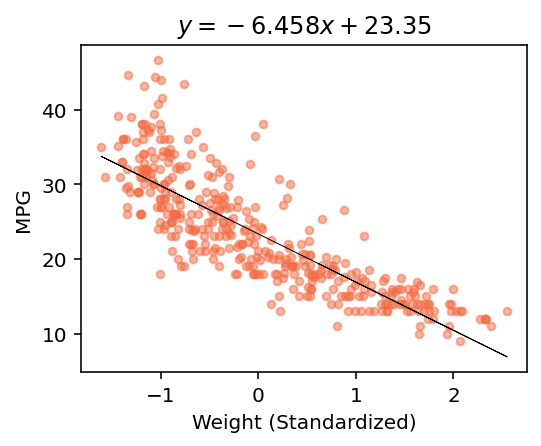

In [24]:
# Randomly initialize slope and y-intercept
m = np.random.random(size=1)[0]
b = np.random.random(size=1)[0]
learning_rate = .001 # learning rate is much faster for normalized variables
nepochs=10           # needs many fewer iterations
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - y))
        print(f"Epoch {epoch:5d} {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
carshow(m, b, X=X, y=df_cars.MPG)

## Training regressor using pytorch's autograd

In [25]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1).float()
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

Epoch     0 1.76,0.38: MSE loss      618.433 MAE    23.06
Epoch    10 -6.44,23.31: MSE loss       18.699 MAE     3.27
LAST        -6.47,23.36: MSE loss       18.699 MAE     3.27


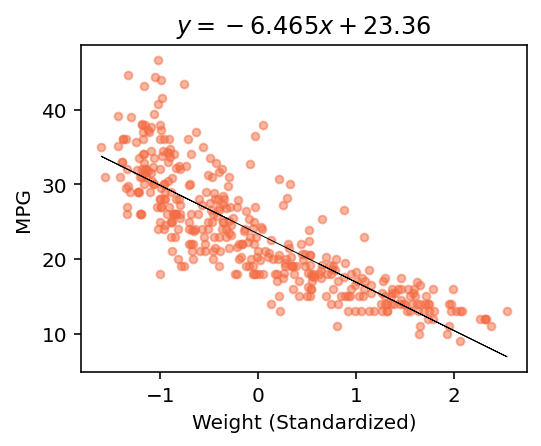

In [26]:
# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True) # too far away from correct answer for one learning rate
learning_rate = .2
nepochs=10
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:5d} {m.detach().item():4.2f},{b.detach().item():4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    with torch.no_grad():
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
#     print(m.detach().item(), b.detach().item())
    # Zero the gradients
    m.grad.zero_()
    b.grad.zero_()

m = m.detach().item()
b = b.detach().item()
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
carshow(m, b, X=X, y=df_cars.MPG)